In [1]:
import os

def explore_dataset(root_dir):
    # Dictionary to hold the number of files in each category
    category_summary = {}

    # Walk through the directory
    for category in os.listdir(root_dir):
        category_path = os.path.join(root_dir, category)
        if os.path.isdir(category_path):
            num_files = 0
            for root, _, files in os.walk(category_path):
                num_files += len([file for file in files if file.endswith(".jpg")])
            category_summary[category] = num_files

    # Print out the summary of each category
    for category, count in category_summary.items():
        print(f"Category: {category} - Number of Images: {count}")

# Path to your dataset
root_dir = "/media/pria/New Volume/Spoofing/Datasets/2020-plosone-recod-mpad/"

# Explore the dataset
explore_dataset(root_dir)


Category: attack_cce - Number of Images: 28800
Category: attack_hp - Number of Images: 28800
Category: attack_print1 - Number of Images: 28800
Category: attack_print2 - Number of Images: 28800
Category: real - Number of Images: 28800


Train set size: 46080
Validation set size: 11520
Test set size: 57600


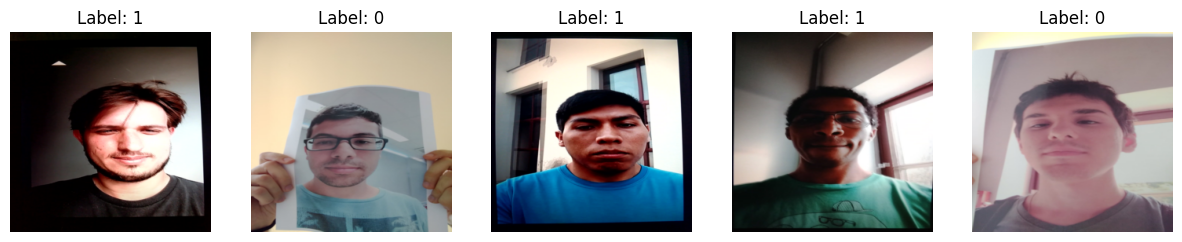

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torchvision import transforms
import matplotlib.image as mpimg
import torch.nn as nn
import torch.optim as optim

# Define the custom dataset class
class SpoofDataset(Dataset):
    def __init__(self, root_dir, category, label, transform=None):
        self.root_dir = os.path.join(root_dir, category)
        self.transform = transform
        self.data = []
        self.label = label
        
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith(".jpg"):
                    self.data.append(os.path.join(root, file))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = mpimg.imread(img_path)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(self.label, dtype=torch.long)

# Define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load the datasets
root_dir = "/media/pria/New Volume/Spoofing/Datasets/2020-plosone-recod-mpad/"
attack_print1_dataset = SpoofDataset(root_dir=root_dir, category="attack_print1", label=0, transform=transform)
attack_hp_dataset = SpoofDataset(root_dir=root_dir, category="attack_hp", label=1, transform=transform)

# Combine the datasets for training and validation
combined_train_dataset = ConcatDataset([attack_print1_dataset, attack_hp_dataset])

# Split the combined dataset into training and validation sets
train_size = int(0.8 * len(combined_train_dataset))
val_size = len(combined_train_dataset) - train_size

train_dataset, val_dataset = random_split(combined_train_dataset, [train_size, val_size])

# Load the "attack_print2" and "attack_cce" datasets for testing
test_print2_dataset = SpoofDataset(root_dir=root_dir, category="attack_print2", label=0, transform=transform)
test_cce_dataset = SpoofDataset(root_dir=root_dir, category="attack_cce", label=1, transform=transform)

# Combine the test datasets
combined_test_dataset = ConcatDataset([test_print2_dataset, test_cce_dataset])

# Create DataLoaders for train, validation, and test sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

# Print out sizes for confirmation
print(f"Train set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

# Function to show a few images with their labels
def show_images(dataloader, num_images=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    images = images[:num_images]
    labels = labels[:num_images]
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for idx, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C) for plotting
        axes[idx].imshow(img)
        axes[idx].set_title(f"Label: {label.item()}")
        axes[idx].axis('off')
    plt.show()

# Show a few images from the training set
show_images(train_loader)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import os
import json

# Directory to save model and logs
save_path = './models/trial22'
os.makedirs(save_path, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet50 model and adjust the classifier layer
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(ResNet50Classifier, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Instantiate the model, criterion, and optimizer
model = ResNet50Classifier(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training settings
num_epochs = 5
best_val_accuracy = 0.0
train_log = []

# Training and Validation Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        train_correct += (predictions == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            predictions = torch.round(torch.sigmoid(outputs))
            val_correct += (predictions == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / len(val_loader.dataset)

    # Save the model with the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), os.path.join(save_path, f'best_model.pth'))

    # Log the epoch results
    epoch_log = {
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
    }
    train_log.append(epoch_log)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Save the training log
with open(os.path.join(save_path, 'train_log.json'), 'w') as f:
    json.dump(train_log, f, indent=4)

print("Training complete. Best model saved.")


/home/pria/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pria/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validation Epoch 1/5: 100%|███████████████████| 360/360 [07:07<00:00,  1.19s/it]


Epoch 1/5
Train Loss: 0.0041, Train Accuracy: 0.9986
Validation Loss: 0.0020, Validation Accuracy: 0.9996


Validation Epoch 2/5: 100%|███████████████████| 360/360 [07:08<00:00,  1.19s/it]


Epoch 2/5
Train Loss: 0.0030, Train Accuracy: 0.9991
Validation Loss: 0.0003, Validation Accuracy: 0.9999


Validation Epoch 3/5: 100%|███████████████████| 360/360 [07:09<00:00,  1.19s/it]


Epoch 3/5
Train Loss: 0.0016, Train Accuracy: 0.9995
Validation Loss: 0.0002, Validation Accuracy: 1.0000


Validation Epoch 4/5: 100%|███████████████████| 360/360 [07:08<00:00,  1.19s/it]


Epoch 4/5
Train Loss: 0.0012, Train Accuracy: 0.9997
Validation Loss: 0.0002, Validation Accuracy: 1.0000


Validation Epoch 5/5: 100%|███████████████████| 360/360 [07:09<00:00,  1.19s/it]

Epoch 5/5
Train Loss: 0.0007, Train Accuracy: 0.9998
Validation Loss: 0.0014, Validation Accuracy: 0.9995
Training complete. Best model saved.


## Evalution

## Train set eval

In [6]:
import torch
from tqdm import tqdm
import torch.nn as nn

# Directory where the model is saved
save_path = './models/trial22'
model_save_path = os.path.join(save_path, 'best_model.pth')

# Instantiate the model
model = ResNet50Classifier().to(device)

# Load the best model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Set the model to evaluation mode
model.eval()

# Initialize counters for training set
train_correct = 0
train_total = 0
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

criterion = nn.BCEWithLogitsLoss()
train_loss = 0.0

# Evaluate on the training set
with torch.no_grad():
    for images, labels in tqdm(train_loader, desc="Evaluating Training Set"):
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Ensure labels are [batch_size, 1]
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item() * images.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)

        # Calculate true positives, true negatives, false positives, and false negatives
        for pred, label in zip(predictions, labels):
            if label == 1 and pred == 1:
                true_positives += 1
            elif label == 1 and pred == 0:
                false_negatives += 1
            elif label == 0 and pred == 1:
                false_positives += 1
            else:
                true_negatives += 1

# Calculate metrics
train_loss /= train_total
train_accuracy = train_correct / train_total

# Calculate APCER, BPCER, ACER, HTER, and EER
try:
    apcer = false_positives / (false_positives + true_negatives)
    bpcer = false_negatives / (false_negatives + true_positives)
    acer = (apcer + bpcer) / 2
    hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    eer = bpcer  # Assuming the threshold is set to achieve EER
except ZeroDivisionError:
    apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

# Print out the results
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")


/tmp/ipykernel_1971517/1037799812.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))
Evaluating Tra

Training Loss: 0.0001, Training Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


## Val evaluation

In [5]:
import torch
import os
from tqdm import tqdm
import torch.nn as nn

# Directory where the model is saved
save_path = './models/trial22'
model_save_path = os.path.join(save_path, 'best_model.pth')

# Instantiate the model
model = ResNet50Classifier().to(device)

# Load the best model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Set the model to evaluation mode
model.eval()

# Initialize counters
val_correct = 0
val_total = 0
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

criterion = nn.BCEWithLogitsLoss()
val_loss = 0.0

# Evaluate on the validation set
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Validating"):
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Ensure labels are [batch_size, 1]
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        val_correct += (predictions == labels).sum().item()
        val_total += labels.size(0)

        # Calculate true positives, true negatives, false positives, and false negatives
        for pred, label in zip(predictions, labels):
            if label == 1 and pred == 1:
                true_positives += 1
            elif label == 1 and pred == 0:
                false_negatives += 1
            elif label == 0 and pred == 1:
                false_positives += 1
            else:
                true_negatives += 1

# Calculate metrics
val_loss /= val_total
val_accuracy = val_correct / val_total

# Calculate APCER, BPCER, ACER, HTER, and EER
try:
    apcer = false_positives / (false_positives + true_negatives)
    bpcer = false_negatives / (false_negatives + true_positives)
    acer = (apcer + bpcer) / 2
    hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    eer = bpcer  # Assuming the threshold is set to achieve EER
except ZeroDivisionError:
    apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

# Print out the results
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")


/tmp/ipykernel_1971517/2029848566.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))
Validating: 10

Validation Loss: 0.0002, Validation Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


## Test set Evaluation (cross dataset) 

In [4]:
import torch
import os
from tqdm import tqdm
import torch.nn as nn

# Directory where the model is saved
save_path = './models/trial22'
model_save_path = os.path.join(save_path, 'best_model.pth')

# Instantiate the model
model = ResNet50Classifier().to(device)

# Load the best model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Set the model to evaluation mode
model.eval()

# Initialize counters
test_correct = 0
test_total = 0
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

criterion = nn.BCEWithLogitsLoss()
test_loss = 0.0

# Evaluate on the test set
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing on Print2"):
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Ensure labels are [batch_size, 1]
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        test_correct += (predictions == labels).sum().item()
        test_total += labels.size(0)

        # Calculate true positives, true negatives, false positives, and false negatives
        for pred, label in zip(predictions, labels):
            if label == 1 and pred == 1:
                true_positives += 1
            elif label == 1 and pred == 0:
                false_negatives += 1
            elif label == 0 and pred == 1:
                false_positives += 1
            else:
                true_negatives += 1

# Calculate metrics
test_loss /= test_total
test_accuracy = test_correct / test_total

# Calculate APCER, BPCER, ACER, HTER, and EER
try:
    apcer = false_positives / (false_positives + true_negatives)
    bpcer = false_negatives / (false_negatives + true_positives)
    acer = (apcer + bpcer) / 2
    hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    eer = bpcer  # Assuming the threshold is set to achieve EER
except ZeroDivisionError:
    apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

# Print out the results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")


/tmp/ipykernel_1971517/647471702.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))
Testing on Prin

Test Loss: 1.9607, Test Accuracy: 0.6770
APCER: 0.0024, BPCER: 0.6437, ACER: 0.3230, HTER: 0.3230, EER: 0.6437
